In [2]:
import tensorflow as tf

In [23]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/rice"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4155 files belonging to 5 classes.


In [24]:
class_name = training_set.class_names
class_name

['rice_brown_spot',
 'rice_healthy',
 'rice_hispa',
 'rice_leaf_blast',
 'rice_neck_blast']

In [25]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

260
208
52


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [27]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop])

Epoch 1/10
208/208 [==============================] - 28s 126ms/step - loss: 0.8749 - categorical_accuracy: 0.6391 - val_loss: 0.8472 - val_categorical_accuracy: 0.6626
Epoch 2/10
208/208 [==============================] - 26s 124ms/step - loss: 0.7245 - categorical_accuracy: 0.6968 - val_loss: 0.7884 - val_categorical_accuracy: 0.6868
Epoch 3/10
208/208 [==============================] - 26s 123ms/step - loss: 0.6438 - categorical_accuracy: 0.7344 - val_loss: 0.8478 - val_categorical_accuracy: 0.6747
Epoch 4/10
208/208 [==============================] - 26s 124ms/step - loss: 0.5988 - categorical_accuracy: 0.7557 - val_loss: 0.8260 - val_categorical_accuracy: 0.6965
Epoch 5/10
208/208 [==============================] - 26s 125ms/step - loss: 0.5510 - categorical_accuracy: 0.7767 - val_loss: 0.7543 - val_categorical_accuracy: 0.7170
Epoch 6/10
208/208 [==============================] - 26s 126ms/step - loss: 0.5192 - categorical_accuracy: 0.7846 - val_loss: 0.7429 - val_categorical_acc

In [29]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [30]:
model.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [31]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
208/208 [==============================] - 37s 168ms/step - loss: 1.9399 - categorical_accuracy: 0.5670 - val_loss: 0.8536 - val_categorical_accuracy: 0.6771
Epoch 2/5
208/208 [==============================] - 35s 166ms/step - loss: 0.8137 - categorical_accuracy: 0.6776 - val_loss: 0.8211 - val_categorical_accuracy: 0.6747
Epoch 3/5
208/208 [==============================] - 35s 167ms/step - loss: 0.7325 - categorical_accuracy: 0.6962 - val_loss: 0.7903 - val_categorical_accuracy: 0.6880
Epoch 4/5
208/208 [==============================] - 35s 167ms/step - loss: 0.6407 - categorical_accuracy: 0.7398 - val_loss: 0.8015 - val_categorical_accuracy: 0.6856
Epoch 5/5
208/208 [==============================] - 35s 168ms/step - loss: 0.5824 - categorical_accuracy: 0.7671 - val_loss: 0.8085 - val_categorical_accuracy: 0.6796


In [32]:
train_loss,train_acc = model.evaluate(train_ds)

208/208 [==============================] - 16s 74ms/step - loss: 0.5404 - categorical_accuracy: 0.7849


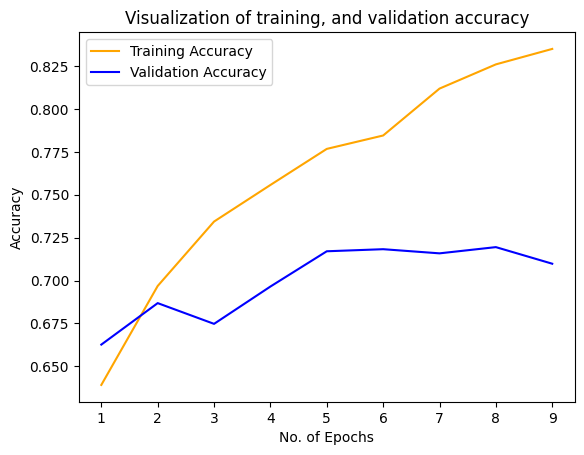

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
epochs=[i for i in range(1,10)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()


In [36]:
model.save("trained_models/trained_model_rice.keras")